The code performs the following tasks:

*  **Dataset-Level Completeness Check:**
Verifies that the dataset header contains all required fields (e.g., metadata attributes such as "ID," "Image Type," "Patient Age").
Reports any missing headers or additional unexpected ones.

*  **Image (Data) Point-Level Completeness Check:**
Ensures that each data point (image record) includes complete metadata. Flags records with missing or null values in any required field.

*  **Metadata Value Accuracy Assessment:**
Identifies inaccurate metadata values (e.g., invalid age ranges, unsupported formats for metadata entries).
Validates metadata consistency across the dataset (e.g., ensuring patient ages are within biologically plausible ranges).

In [1]:
# Install required libraries
!pip install pydicom
!pip install pandas rapidfuzz
#!pip install openai==0.28
!pip install openai transformers pandas torch accelerate



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.4 MB/s eta 0:00:00


In [16]:
# Load required libraries
import pandas as pd
import json
import pydicom
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from IPython.display import display
from ipywidgets import FileUpload
import matplotlib.pyplot as plt
import json
from rapidfuzz import fuzz, process
import openai
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from rapidfuzz import fuzz, process
import json

The list of functions below load datasets' metadata from:
1. **CSV File (Comma-Separated Values):** A tabular format where each row represents a data point, and each column contains metadata attributes. It is widely used due to its simplicity and compatibility with various tools.


2. **JSON File (JavaScript Object Notatio):** A hierarchical format that stores metadata as key-value pairs. JSON files are highly flexible and commonly used for nested or complex metadata structures.

3. **DICOM File (Digital Imaging and Communications in Medicine):** A standard file format in medical imaging that embeds both the image and its metadata. Metadata includes critical information like patient demographics, imaging modality, and acquisition settings.




In [3]:
def get_file_path():
    """
    Ask the user to provide the file path and clean up the input.

    Returns:
        str: Path to the file provided by the user, with unnecessary quotes stripped.
    """
    file_path = input("Enter the full path to the file (e.g., '/path/to/file.csv'): ").strip()
    # Remove quotes if the user provides the path enclosed in single or double quotes
    if (file_path.startswith("'") and file_path.endswith("'")) or (file_path.startswith('"') and file_path.endswith('"')):
        file_path = file_path[1:-1]
    return file_path



In [4]:
def load_dataset_csv(file_path):
    """
    Load a CSV file containing the dataset metadata.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Loaded CSV as a DataFrame.
    """
    try:
        data = pd.read_csv(file_path)
        return data
    except Exception as e:
        print(f"Error loading dataset CSV: {e}")
        return None


In [5]:

def load_json(file_path):
    """
    Load a JSON file from the provided path and return a dictionary or list.

    Args:
        file_path (str): Path to the JSON file.

    Returns:
        dict or list: Parsed JSON content.
        None: If the file cannot be processed.
    """
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        return data
    except Exception as e:
        print(f"Error loading JSON: {e}")
        return None


In [5]:

def load_dicom(file_path):
    """
    Load a DICOM file from the provided path and extract metadata into a dictionary.

    Args:
        file_path (str): Path to the DICOM file.

    Returns:
        dict: Metadata extracted from the DICOM file.
        None: If the file cannot be processed.
    """
    try:
        dicom_data = pydicom.dcmread(file_path)
        metadata = {elem.tag: elem.value for elem in dicom_data}
        return metadata
    except Exception as e:
        print(f"Error loading DICOM: {e}")
        return None


In [6]:
def load_required_fields_csv(file_path):
    """
    Load a CSV file containing the list of required fields.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        list: List of required metadata fields.
    """
    try:
        data = pd.read_csv(file_path, header=None)  # No header expected
        return data.iloc[:, 0].dropna().tolist()  # Extract the first column as a list
    except Exception as e:
        print(f"Error loading required fields CSV: {e}")
        return None


In [7]:
def get_required_metadata():
    """
    Load the required metadata fields from a CSV file provided by the user.

    Returns:
        list: List of required metadata fields.
    """
    print("Provide the path to the required metadata fields CSV file.")
    required_fields_path = get_file_path()
    required_fields = load_required_fields_csv(required_fields_path)

    if required_fields is None or len(required_fields) == 0:
        print("Failed to load the required metadata fields file or the file is empty.")
        return []

    print(f"Required fields: {required_fields}")
    return required_fields


In [8]:
def main():
    """
    Main workflow for selecting a file format, providing the file path, and loading the file.
    """
    # Step 1: Ask the user to specify the file format
    file_format = input("Enter the file format (CSV, JSON, DICOM): ").strip().upper()

    # Step 2: Get the file path from the user
    file_path = get_file_path()

    # Step 3: Process the file based on the format
    if file_format == 'CSV':
        data = load_dataset_csv(file_path)
    elif file_format == 'JSON':
        data = load_json(file_path)
    elif file_format == 'DICOM':
        data = load_dicom(file_path)
    else:
        print(f"Unsupported file format: {file_format}")
        return

    # Step 4: Display the loaded data
    if data is not None and not data.empty:  # Fix ambiguity for DataFrame
        print(f"Loaded {file_format} file successfully.")
        if isinstance(data, pd.DataFrame):
            print(data.head())  # Display the first 5 rows if it's a DataFrame
        elif isinstance(data, list):
            print(data[:5])  # Display the first 5 items if it's a list
        else:
            print(data)  # Display the raw data
    else:
        print(f"Failed to load {file_format} file or the file is empty.")

main()

Enter the file format (CSV, JSON, DICOM): CSV
Enter the full path to the file (e.g., '/path/to/file.csv'): /content/VinDr_metadata.csv
Loaded CSV file successfully.
                   SOP Instance UID               Series Instance UID  \
0  d8125545210c08e1b1793a5af6458ee2  b36517b9cbbcfd286a7ae04f643af97a   
1  290c658f4e75a3f83ec78a847414297c  b36517b9cbbcfd286a7ae04f643af97a   
2  cd0fc7bc53ac632a11643ac4cc91002a  b36517b9cbbcfd286a7ae04f643af97a   
3  71638b1e853799f227492bfb08a01491  b36517b9cbbcfd286a7ae04f643af97a   
4  dd9ce3288c0773e006a294188aadba8e  d931832a0815df082c085b6e09d20aac   

                 SOP Instance UID.1 Patient's Age View Position  \
0  d8125545210c08e1b1793a5af6458ee2          053Y            CC   
1  290c658f4e75a3f83ec78a847414297c          053Y           MLO   
2  cd0fc7bc53ac632a11643ac4cc91002a          053Y            CC   
3  71638b1e853799f227492bfb08a01491          053Y           MLO   
4  dd9ce3288c0773e006a294188aadba8e          042Y            

In [10]:
required_fields = get_required_metadata()


Provide the path to the required metadata fields CSV file.
Enter the full path to the file (e.g., '/path/to/file.csv'): /content/required_metadata_fields.csv
Required fields: ['Patient ID', 'Patient Birth Date/Age', 'Patient Sex', 'Time since last cancer diagnosis', 'Race', 'Ethnicity', 'First degree', 'Marital status', 'Zip code', 'Study ID', 'Study Date', 'Study Time', 'Modality', 'Image Type', 'Image ID', 'Image Dimension', 'Resolution', 'Manufacturer', 'Manufacturer/Model', 'Manufacturer/Year', 'Manufacturer/Regulatory', 'File Format', 'Compression Type', 'Bits Stored', 'Pixel Spacing', 'Breast view']


 **Dataset-Level Completeness Check:**
Verifies that the dataset header contains all required fields (e.g., metadata attributes such as "ID," "Image Type," "Patient Age").
Reports any missing headers or additional unexpected ones.

In [11]:
def dataset_level_completeness_check(dataset_df, required_fields):
    """
    Perform a dataset-level completeness check to verify that the dataset header contains all required fields.

    Args:
        dataset_df (pd.DataFrame): The dataset as a pandas DataFrame.
        required_fields (list): List of required metadata fields.

    Returns:
        dict: A dictionary containing missing headers and unexpected headers.
    """
    dataset_headers = dataset_df.columns.tolist()  # Extract the headers from the dataset

    # Identify missing and unexpected headers
    missing_headers = [field for field in required_fields if field not in dataset_headers]
    unexpected_headers = [field for field in dataset_headers if field not in required_fields]

    # Report findings
    return {
        "missing_headers": missing_headers,
        "unexpected_headers": unexpected_headers,
    }

def compute_completeness_score(missing_headers, required_fields):
    """
    Compute the completeness score based on the presence or absence of required fields.

    Args:
        missing_headers (list): List of required fields missing from the dataset.
        required_fields (list): List of all required metadata fields.

    Returns:
        float: Completeness score (value between 0 and 1).
    """
    total_required = len(required_fields)  # Total number of required fields
    missing_count = len(missing_headers)  # Number of missing fields

    if total_required == 0:
        return 0.0  # Avoid division by zero, no required fields means completeness is zero

    present_count = total_required - missing_count  # Number of fields present
    completeness_score = present_count / total_required
    return completeness_score


In [12]:
# Step 1: Load required metadata fields
# This step reads the required fields from a CSV file that contains a single column listing all expected metadata attributes (e.g., 'PatientID', 'Modality', 'StudyDate').
required_fields = get_required_metadata()

# Step 2: Load the dataset
# This step loads the dataset (a multi-column CSV file) into a pandas DataFrame. Each column represents a metadata attribute (e.g., 'PatientID', 'Modality'), and each row represents a data point.
dataset_path = '/content/VinDr_metadata.csv'  # Replace with your dataset's file path
dataset_df = load_dataset_csv(dataset_path)

# Step 3: Perform dataset-level completeness check
# This checks if the dataset's headers (column names) match the required fields.
# - Missing Headers: Required fields that are not present in the dataset.
# - Unexpected Headers: Fields present in the dataset that are not part of the required fields.
if dataset_df is not None and required_fields:
    completeness_report = dataset_level_completeness_check(dataset_df, required_fields)

    # Extract missing and unexpected headers for clarity
    missing_headers = completeness_report["missing_headers"]
    unexpected_headers = completeness_report["unexpected_headers"]

    # Step 4: Report Missing Headers
    # If there are required fields missing from the dataset, list them.
    if missing_headers:
        print(f"Missing Headers: {missing_headers}")
    else:
        print("No missing headers. All required fields are present.")

    # Step 5: Report Unexpected Headers
    # If the dataset contains extra fields not listed in the required fields, list them.
    if unexpected_headers:
        print(f"Unexpected Headers: {unexpected_headers}")
    else:
        print("No unexpected headers. All dataset fields are required.")

    # Step 6: Compute Completeness Score
    # The completeness score evaluates the proportion of required fields that are present in the dataset.
    completeness_score = compute_completeness_score(missing_headers, required_fields)
    print(f"Completeness Score: {completeness_score:.2f}")
else:
    # Handle cases where either the dataset or required fields failed to load.
    print("Failed to load dataset or required fields.")


Provide the path to the required metadata fields CSV file.
Enter the full path to the file (e.g., '/path/to/file.csv'): /content/required_metadata_fields.csv
Required fields: ['Patient ID', 'Patient Birth Date/Age', 'Patient Sex', 'Time since last cancer diagnosis', 'Race', 'Ethnicity', 'First degree', 'Marital status', 'Zip code', 'Study ID', 'Study Date', 'Study Time', 'Modality', 'Image Type', 'Image ID', 'Image Dimension', 'Resolution', 'Manufacturer', 'Manufacturer/Model', 'Manufacturer/Year', 'Manufacturer/Regulatory', 'File Format', 'Compression Type', 'Bits Stored', 'Pixel Spacing', 'Breast view']
Missing Headers: ['Patient ID', 'Patient Birth Date/Age', 'Patient Sex', 'Time since last cancer diagnosis', 'Race', 'Ethnicity', 'First degree', 'Marital status', 'Zip code', 'Study ID', 'Study Date', 'Study Time', 'Modality', 'Image Type', 'Image ID', 'Image Dimension', 'Resolution', 'Manufacturer/Model', 'Manufacturer/Year', 'Manufacturer/Regulatory', 'File Format', 'Compression Ty

This code performs a dataset-level completeness check to ensure that a metadata file contains all required fields specified in a separate file. However, contrary to the previous cell, the cell below uses fuzzy matching to handle minor variations in field names (e.g., PatientID vs. Patient ID)

In [13]:
import pandas as pd
from rapidfuzz import fuzz, process

# Define file paths
required_fields_path = "/content/required_metadata_fields.csv"
dataset_path = "/content/VinDr_metadata.csv"

# Step 1: Load required metadata fields
def get_required_metadata(file_path):
    """
    Load required metadata fields from a CSV file.
    :param file_path: Path to the CSV file containing required fields.
    :return: A list of required metadata field names.
    """
    required_metadata_df = pd.read_csv(file_path)
    return required_metadata_df.iloc[:, 0].tolist()  # Assume the required fields are in the first column

required_fields = get_required_metadata(required_fields_path)

# Step 2: Load the dataset
def load_dataset_csv(file_path):
    """
    Load dataset metadata from a CSV file.
    :param file_path: Path to the dataset CSV file.
    :return: A pandas DataFrame containing the dataset metadata.
    """
    return pd.read_csv(file_path)

dataset_df = load_dataset_csv(dataset_path)

# Step 3: Perform dataset-level completeness check with fuzzy matching
def dataset_level_completeness_check(dataset_df, required_fields, similarity_threshold=80):
    """
    Perform a dataset-level completeness check with fuzzy matching for metadata fields.
    :param dataset_df: Pandas DataFrame containing dataset metadata.
    :param required_fields: List of required metadata field names.
    :param similarity_threshold: Minimum similarity score (0-100) to consider fields as matches.
    :return: A dictionary containing missing headers, unexpected headers, and field mappings.
    """
    dataset_headers = dataset_df.columns.tolist()
    field_mappings = {}
    missing_headers = []
    used_headers = set()

    # Perform fuzzy matching
    for required_field in required_fields:
        # Find the best match for each required field in dataset headers
        result = process.extractOne(required_field, dataset_headers, scorer=fuzz.ratio)
        if result is not None:
            match, score, _ = result  # Unpack the match, score, and additional data
            if score >= similarity_threshold:
                field_mappings[required_field] = match
                used_headers.add(match)
            else:
                missing_headers.append(required_field)
        else:
            missing_headers.append(required_field)

    # Identify unexpected headers
    unexpected_headers = [header for header in dataset_headers if header not in used_headers]

    return {
        "missing_headers": missing_headers,
        "unexpected_headers": unexpected_headers,
        "field_mappings": field_mappings,
    }


# Perform completeness check
completeness_report = dataset_level_completeness_check(dataset_df, required_fields)

# Step 4: Extract and display results
missing_headers = completeness_report["missing_headers"]
unexpected_headers = completeness_report["unexpected_headers"]
field_mappings = completeness_report["field_mappings"]

print(f"Field Mappings: {field_mappings}")
if missing_headers:
    print(f"Missing Headers: {missing_headers}")
else:
    print("No missing headers. All required fields are present.")

if unexpected_headers:
    print(f"Unexpected Headers: {unexpected_headers}")
else:
    print("No unexpected headers. All dataset fields are required.")

# Step 5: Compute Completeness Score
def compute_completeness_score(missing_headers, required_fields):
    """
    Compute the completeness score for the dataset based on required fields.
    :param missing_headers: List of required fields not found in the dataset.
    :param required_fields: List of all required fields.
    :return: Completeness score as a percentage.
    """
    missing_count = len(missing_headers)
    total_required = len(required_fields)
    return ((total_required - missing_count) / total_required) * 100

completeness_score = compute_completeness_score(missing_headers, required_fields)
print(f"Completeness Score: {completeness_score:.2f}%")


Field Mappings: {'Manufacturer': 'Manufacturer', 'Manufacturer/Model': 'Manufacturer', 'Manufacturer/Year': 'Manufacturer', 'Pixel Spacing': 'Pixel Spacing'}
Missing Headers: ['Patient Birth Date/Age', 'Patient Sex', 'Time since last cancer diagnosis', 'Race', 'Ethnicity', 'First degree', 'Marital status', 'Zip code', 'Study ID', 'Study Date', 'Study Time', 'Modality', 'Image Type', 'Image ID', 'Image Dimension', 'Resolution', 'Manufacturer/Regulatory', 'File Format', 'Compression Type', 'Bits Stored', 'Breast view']
Unexpected Headers: ['SOP Instance UID', 'Series Instance UID', 'SOP Instance UID.1', "Patient's Age", 'View Position', 'Image Laterality', 'Photometric Interpretation', 'Rows', 'Columns', 'Imager Pixel Spacing', 'Pixel Padding Value', 'Pixel Padding Range Limit', 'Window Center', 'Window Width', 'Rescale Intercept', 'Rescale Slope', 'Rescale Type', 'Window Center & Width Explanation', "Manufacturer's Model Name"]
Completeness Score: 16.00%


## Enhancing Metadata Completeness Scoring Algorithm

Note that the code above already improved the completeness score, increasing it from 0.08% to 16%. This was achieved by relaxing the requirement for exact matches and allowing the algorithm to consider metadata fields with similar names.

To further enhance the algorithm and handle cases like detecting `'Patient Birth Date/Age'` and `'Patient's Age'`, we implement the following improvements:

### Issue:
The fuzzy matching algorithm relies solely on string similarity, which is insufficient for:
- Handling semantic relationships.
- Managing complex phrases or variations in naming conventions.

For example:
- `"Patient Birth Date/Age"` vs. `"Patient's Age"` may have moderate similarity but fail to match.
- `"Manufacturer/Model"` vs. `"Manufacturer's Model"` are semantically equivalent but do not map well.

### Solution:
To address these limitations, we enhance the algorithm with:
1. **Custom Synonyms Dictionary:**
   - Predefine mappings for commonly misaligned fields, e.g., `"Patient Birth Date/Age"` → `["Patient's Age", "Birth Date"]`.
   - This ensures precise matches for known variations.
   
2. **Improved Fuzzy Matching:**
   - Combine fuzzy matching with the custom synonyms dictionary.
   - Use fuzzy matching as a fallback for fields not mapped by the custom dictionary.
   - Set a similarity threshold (e.g., 80%) to prioritize better matches.

These improvements ensure the algorithm handles both semantic relationships and naming variations effectively, improving metadata completeness scoring further.


In [14]:
# Enhanced Dataset-Level Completeness Check with Custom Synonyms and Fuzzy Matching

# First, we create a custom dictionary that defines variations of metadata names.
# This dictionary can be dynamically updated whenever a new dataset is included.
custom_synonyms = {
    "Patient Birth Date/Age": ["Patient's Age", "Birth Date"],
    "Manufacturer/Model": ["Manufacturer's Model Name"],
    "Resolution": ["Image Resolution"],
    "Breast orientation": ["View Position"],
    "Modality": ["Image Modality"],
}

# This function combines custom synonym matching and fuzzy matching to map required metadata fields
# to the dataset's actual metadata fields. It ensures flexibility in handling variations in field names.
def dataset_level_completeness_check(
    dataset_df, required_fields, custom_synonyms=None, similarity_threshold=80
):
    """
    Perform a dataset-level completeness check with enhanced mapping for metadata fields.

    This function checks if the required metadata fields are present in the dataset's metadata file. It uses:
    1. **Custom Synonyms:** To handle known variations of field names.
    2. **Fuzzy Matching:** As a fallback to identify approximate matches based on string similarity.

    Parameters:
    - dataset_df (pd.DataFrame): Pandas DataFrame containing dataset metadata.
    - required_fields (list): List of required metadata field names.
    - custom_synonyms (dict): Dictionary of custom mappings for known field synonyms. Default is None.
    - similarity_threshold (int): Minimum similarity score (0-100) to consider fields as matches. Default is 80.

    Returns:
    dict: A dictionary containing:
        - "missing_headers": List of required fields not found in the dataset.
        - "unexpected_headers": List of dataset fields that are not required.
        - "field_mappings": Mapping of required fields to matched dataset fields.
    """
    # Extract dataset headers
    dataset_headers = dataset_df.columns.tolist()

    # Initialize outputs
    field_mappings = {}
    missing_headers = []
    used_headers = set()

    # Initialize the custom synonyms dictionary if not provided
    if custom_synonyms is None:
        custom_synonyms = {}

    # Perform mapping with custom synonyms and fuzzy matching
    for required_field in required_fields:
        # Step 1: Check custom synonyms
        if required_field in custom_synonyms:
            possible_matches = custom_synonyms[required_field]
            match = next((header for header in dataset_headers if header in possible_matches), None)
            if match:
                field_mappings[required_field] = match
                used_headers.add(match)
                continue

        # Step 2: Fallback to fuzzy matching
        result = process.extractOne(required_field, dataset_headers, scorer=fuzz.ratio)
        if result is not None:
            match, score, _ = result  # Extract match and similarity score
            if score >= similarity_threshold:
                field_mappings[required_field] = match
                used_headers.add(match)
            else:
                missing_headers.append(required_field)
        else:
            missing_headers.append(required_field)

    # Identify unexpected headers
    unexpected_headers = [header for header in dataset_headers if header not in used_headers]

    return {
        "missing_headers": missing_headers,
        "unexpected_headers": unexpected_headers,
        "field_mappings": field_mappings,
    }

# Example usage
# Load required metadata fields and dataset metadata
required_fields = get_required_metadata(required_fields_path)
dataset_df = load_dataset_csv(dataset_path)

# Define custom synonyms for better matching
custom_synonyms = {
    "Patient Birth Date/Age": ["Patient's Age", "Birth Date"],
    "Manufacturer/Model": ["Manufacturer's Model Name"],
    "Resolution": ["Image Resolution"],
    "Breast orientation": ["View Position"],
    "Modality": ["Image Modality"],
}

# Perform enhanced completeness check
completeness_report = dataset_level_completeness_check(
    dataset_df, required_fields, custom_synonyms=custom_synonyms
)

# Extract and display results
missing_headers = completeness_report["missing_headers"]
unexpected_headers = completeness_report["unexpected_headers"]
field_mappings = completeness_report["field_mappings"]

print(f"Field Mappings: {field_mappings}")
if missing_headers:
    print(f"Missing Headers: {missing_headers}")
else:
    print("No missing headers. All required fields are present.")

if unexpected_headers:
    print(f"Unexpected Headers: {unexpected_headers}")
else:
    print("No unexpected headers. All dataset fields are required.")

# Compute completeness score
def compute_completeness_score(missing_headers, required_fields):
    """
    Compute the completeness score for the dataset based on required fields.

    Parameters:
    - missing_headers (list): List of required fields not found in the dataset.
    - required_fields (list): List of all required fields.

    Returns:
    float: Completeness score as a percentage.
    """
    missing_count = len(missing_headers)
    total_required = len(required_fields)
    return ((total_required - missing_count) / total_required) * 100

completeness_score = compute_completeness_score(missing_headers, required_fields)
print(f"Completeness Score: {completeness_score:.2f}%")


Field Mappings: {'Patient Birth Date/Age': "Patient's Age", 'Manufacturer': 'Manufacturer', 'Manufacturer/Model': "Manufacturer's Model Name", 'Manufacturer/Year': 'Manufacturer', 'Pixel Spacing': 'Pixel Spacing'}
Missing Headers: ['Patient Sex', 'Time since last cancer diagnosis', 'Race', 'Ethnicity', 'First degree', 'Marital status', 'Zip code', 'Study ID', 'Study Date', 'Study Time', 'Modality', 'Image Type', 'Image ID', 'Image Dimension', 'Resolution', 'Manufacturer/Regulatory', 'File Format', 'Compression Type', 'Bits Stored', 'Breast view']
Unexpected Headers: ['SOP Instance UID', 'Series Instance UID', 'SOP Instance UID.1', 'View Position', 'Image Laterality', 'Photometric Interpretation', 'Rows', 'Columns', 'Imager Pixel Spacing', 'Pixel Padding Value', 'Pixel Padding Range Limit', 'Window Center', 'Window Width', 'Rescale Intercept', 'Rescale Slope', 'Rescale Type', 'Window Center & Width Explanation']
Completeness Score: 20.00%


In [15]:
# Path to the mapping dictionary file
dictionary_path = "/content/mapping_dictionary.json"

# Function to load the existing dictionary or create a new one
def load_mapping_dictionary(path):
    """
    Load the mapping dictionary from a JSON file. If the file does not exist, return an empty dictionary.
    :param path: Path to the JSON file.
    :return: Mapping dictionary.
    """
    try:
        with open(path, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        return {}

# Function to save the updated dictionary
def save_mapping_dictionary(dictionary, path):
    """
    Save the mapping dictionary to a JSON file.
    :param dictionary: Mapping dictionary to save.
    :param path: Path to the JSON file.
    """
    with open(path, "w") as f:
        json.dump(dictionary, f, indent=4)

# Function to update the mapping dictionary with new dataset metadata
def update_mapping_dictionary(dataset_headers, required_fields, mapping_dict, similarity_threshold=80):
    """
    Update the mapping dictionary by identifying missing mappings and prompting the user for input.
    :param dataset_headers: List of dataset headers.
    :param required_fields: List of required fields.
    :param mapping_dict: Existing mapping dictionary.
    :param similarity_threshold: Minimum similarity score for fuzzy matching.
    :return: Updated mapping dictionary.
    """
    for required_field in required_fields:
        # Skip fields already in the dictionary
        if required_field in mapping_dict:
            continue

        # Use fuzzy matching to find potential matches
        result = process.extractOne(required_field, dataset_headers, scorer=fuzz.ratio)
        if result:
            match, score, _ = result
            if score >= similarity_threshold:
                print(f"Suggested match for '{required_field}': '{match}' (Score: {score})")
                user_input = input(f"Accept this match? (yes/no): ").strip().lower()
                if user_input == "yes":
                    mapping_dict[required_field] = [match]
                    continue

        # Prompt user for manual input
        print(f"No suitable match found for '{required_field}'.")
        user_input = input(f"Enter the correct mapping(s) for '{required_field}' (comma-separated): ").strip()
        if user_input:
            mapping_dict[required_field] = [field.strip() for field in user_input.split(",")]

    return mapping_dict

# Load dataset and required fields
dataset_headers = dataset_df.columns.tolist()
required_fields = get_required_metadata(required_fields_path)

# Load the existing dictionary
mapping_dict = load_mapping_dictionary(dictionary_path)

# Update the dictionary
updated_dict = update_mapping_dictionary(dataset_headers, required_fields, mapping_dict)

# Save the updated dictionary
save_mapping_dictionary(updated_dict, dictionary_path)

print("Mapping dictionary updated and saved successfully!")


No suitable match found for 'Patient Sex'.
Enter the correct mapping(s) for 'Patient Sex' (comma-separated): MM
No suitable match found for 'Time since last cancer diagnosis'.
Enter the correct mapping(s) for 'Time since last cancer diagnosis' (comma-separated): MM
No suitable match found for 'Race'.
Enter the correct mapping(s) for 'Race' (comma-separated): MM
No suitable match found for 'Ethnicity'.
Enter the correct mapping(s) for 'Ethnicity' (comma-separated): MM
No suitable match found for 'First degree'.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [17]:
# Load the mapping dictionary
dictionary_path = "/content/mapping_dictionary.json"

def load_mapping_dictionary(path):
    """
    Load the mapping dictionary from a JSON file.
    :param path: Path to the JSON file.
    :return: Mapping dictionary.
    """
    try:
        with open(path, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        return {}

# Function to compute the completeness score
def compute_completeness_score(dataset_headers, required_fields, mapping_dict, similarity_threshold=80):
    """
    Compute the completeness score based on fuzzy matching and the updated dictionary.
    :param dataset_headers: List of dataset headers.
    :param required_fields: List of required fields.
    :param mapping_dict: Mapping dictionary with predefined mappings.
    :param similarity_threshold: Minimum similarity score for fuzzy matching.
    :return: Completeness score and detailed mapping information.
    """
    matched_fields = set()
    missing_fields = []

    for required_field in required_fields:
        # Check if the required field has a direct mapping in the dictionary
        if required_field in mapping_dict:
            synonyms = mapping_dict[required_field]
            for synonym in synonyms:
                if synonym in dataset_headers:
                    matched_fields.add(synonym)
                    break
            else:
                missing_fields.append(required_field)
        else:
            # Fallback to fuzzy matching if no mapping exists
            result = process.extractOne(required_field, dataset_headers, scorer=fuzz.ratio)
            if result:
                match, score, _ = result
                if score >= similarity_threshold:
                    matched_fields.add(match)
                else:
                    missing_fields.append(required_field)
            else:
                missing_fields.append(required_field)

    # Calculate the completeness score
    completeness_score = (len(required_fields) - len(missing_fields)) / len(required_fields) * 100

    return {
        "completeness_score": completeness_score,
        "matched_fields": list(matched_fields),
        "missing_fields": missing_fields
    }

# Example usage:
# Load required metadata fields and dataset metadata
required_fields = get_required_metadata(required_fields_path)
dataset_df = load_dataset_csv(dataset_path)

# Load the updated dictionary
mapping_dict = load_mapping_dictionary(dictionary_path)

# Compute completeness score
completeness_report = compute_completeness_score(dataset_df, required_fields, mapping_dict)

# Output results
print("Completeness Score:", completeness_report["completeness_score"])
print("Matched Fields:", completeness_report["matched_fields"])
print("Missing Fields:", completeness_report["missing_fields"])



Completeness Score: 8.0
Matched Fields: ["Manufacturer's Model Name", "Patient's Age"]
Missing Fields: ['Patient Sex', 'Time since last cancer diagnosis', 'Race', 'Ethnicity', 'First degree', 'Marital status', 'Zip code', 'Study ID', 'Study Date', 'Study Time', 'Modality', 'Image Type', 'Image ID', 'Image Dimension', 'Resolution', 'Manufacturer', 'Manufacturer/Year', 'Manufacturer/Regulatory', 'File Format', 'Compression Type', 'Bits Stored', 'Pixel Spacing', 'Breast view']


In [11]:
import openai

# List available models
models = openai.Model.list()
for model in models['data']:
    print(model['id'])


dall-e-2
gpt-4o-mini
gpt-3.5-turbo
gpt-3.5-turbo-0125
gpt-3.5-turbo-instruct
babbage-002
o1-mini
o1-mini-2024-09-12
whisper-1
dall-e-3
gpt-3.5-turbo-16k
omni-moderation-latest
o1-preview-2024-09-12
omni-moderation-2024-09-26
tts-1-hd-1106
o1-preview
tts-1-hd
davinci-002
text-embedding-ada-002
gpt-3.5-turbo-1106
tts-1
tts-1-1106
gpt-3.5-turbo-instruct-0914
text-embedding-3-small
gpt-4o-mini-2024-07-18
text-embedding-3-large


In [21]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import pandas as pd

# Load a local LLM using Hugging Face Transformers
def load_local_llm(model_name="EleutherAI/gpt-neo-1.3B"):
    """
    Load a local LLM using Hugging Face Transformers.
    :param model_name: Name of the Hugging Face model to load.
    :return: A text generation pipeline.
    """
    print(f"Loading local LLM: {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    return pipeline("text-generation", model=model, tokenizer=tokenizer)

# Function to assess metadata completeness using a local LLM
def assess_metadata_with_local_llm(required_fields, dataset_headers, local_llm, max_new_tokens=100):
    """
    Assess metadata completeness using a local LLM.
    :param required_fields: List of required metadata fields.
    :param dataset_headers: List of dataset headers.
    :param local_llm: Local LLM pipeline for text generation.
    :param max_new_tokens: Maximum number of new tokens to generate.
    :return: Dictionary with matches, suggestions, and missing fields.
    """
    results = {"matches": {}, "suggestions": {}, "missing": []}

    for field in required_fields:
        prompt = f"""
        Compare the required metadata field: "{field}"
        with this list of dataset fields: {', '.join(dataset_headers[:50])}.
        - Does it match any field? If yes, provide the match.
        - If no match is found, suggest the closest match or note it as missing.
        """
        try:
            # Generate response using the local LLM
            response = local_llm(prompt, max_new_tokens=max_new_tokens, num_return_sequences=1)
            answer = response[0]["generated_text"]

            # Process the response
            if "match" in answer.lower():
                results["matches"][field] = [header for header in dataset_headers if header in answer]
            elif "missing" in answer.lower():
                results["missing"].append(field)
            if "suggest" in answer.lower():
                results["suggestions"][field] = answer

        except Exception as e:
            print(f"Error processing field '{field}': {e}")
            results["missing"].append(field)

    return results

# Utility function to load required metadata from a CSV file
def get_required_metadata(filepath):
    """
    Load required metadata fields from a CSV file.
    """
    return pd.read_csv(filepath).iloc[:, 0].tolist()

# Utility function to load dataset metadata as a DataFrame
def load_dataset_csv(filepath):
    """
    Load dataset metadata from a CSV file.
    """
    return pd.read_csv(filepath)

# Example usage
required_fields_path = "/content/required_metadata_fields.csv"  # Path to required metadata fields
dataset_path = "/content/VinDr_metadata.csv"  # Path to dataset metadata

# Load required metadata fields and dataset headers
required_fields = get_required_metadata(required_fields_path)
dataset_df = load_dataset_csv(dataset_path)
dataset_headers = dataset_df.columns.tolist()

# Load a local LLM
local_llm = load_local_llm(model_name="EleutherAI/gpt-neo-1.3B")  # Use a smaller model if resources are limited

# Call the function with the local LLM
metadata_results = assess_metadata_with_local_llm(required_fields, dataset_headers, local_llm, max_new_tokens=50)

# Print results
print("Matches:", metadata_results["matches"])
print("Suggestions:", metadata_results["suggestions"])
print("Missing Fields:", metadata_results["missing"])


Loading local LLM: EleutherAI/gpt-neo-1.3B...


Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id

Matches: {'Patient Birth Date/Age': ['SOP Instance UID', 'Series Instance UID', 'SOP Instance UID.1', "Patient's Age", 'View Position', 'Image Laterality', 'Photometric Interpretation', 'Rows', 'Columns', 'Imager Pixel Spacing', 'Pixel Spacing', 'Pixel Padding Value', 'Pixel Padding Range Limit', 'Window Center', 'Window Width', 'Rescale Intercept', 'Rescale Slope', 'Rescale Type', 'Window Center & Width Explanation', 'Manufacturer', "Manufacturer's Model Name"], 'Patient Sex': ['SOP Instance UID', 'Series Instance UID', 'SOP Instance UID.1', "Patient's Age", 'View Position', 'Image Laterality', 'Photometric Interpretation', 'Rows', 'Columns', 'Imager Pixel Spacing', 'Pixel Spacing', 'Pixel Padding Value', 'Pixel Padding Range Limit', 'Window Center', 'Window Width', 'Rescale Intercept', 'Rescale Slope', 'Rescale Type', 'Window Center & Width Explanation', 'Manufacturer', "Manufacturer's Model Name"], 'Time since last cancer diagnosis': ['SOP Instance UID', 'Series Instance UID', 'SOP 

In [22]:
import os
from transformers import pipeline

# Function to load local LLM using Hugging Face
def load_local_llm():
    """
    Load a local LLM using Hugging Face.
    """
    print("Loading local LLM...")
    return pipeline("text-generation", model="gpt2")

# Function to assess metadata completeness using LLM
def assess_metadata_with_llm(required_fields, dataset_headers, use_openai=False, model="gpt-3.5-turbo"):
    """
    Assess metadata completeness using LLM (OpenAI or Hugging Face).
    :param required_fields: List of required metadata fields.
    :param dataset_headers: List of dataset headers.
    :param use_openai: Whether to use OpenAI API or fallback to Hugging Face.
    :param model: Model to use for OpenAI or Hugging Face pipeline.
    :return: Dictionary with matches, suggestions, and missing fields.
    """
    results = {"matches": {}, "suggestions": {}, "missing": []}

    # Load local LLM if OpenAI API is unavailable
    local_llm = None
    if not use_openai:
        local_llm = load_local_llm()

    for field in required_fields:
        prompt = f"""
        Compare the required metadata field: "{field}"
        with this list of dataset fields: {dataset_headers}.
        - If a match exists, provide the closest match.
        - Otherwise, suggest the closest match or note it as missing.
        """

        try:
            if use_openai:
                # Use OpenAI API
                response = openai.ChatCompletion.create(
                    model=model,
                    messages=[
                        {"role": "system", "content": "You are a metadata analysis assistant."},
                        {"role": "user", "content": prompt}
                    ]
                )
                answer = response["choices"][0]["message"]["content"]
            else:
                # Use Hugging Face LLM
                response = local_llm(prompt, max_length=150, num_return_sequences=1, truncation=True)
                answer = response[0]["generated_text"]

            # Process the response to extract concise matches/suggestions
            if "match" in answer.lower():
                best_match = [
                    header for header in dataset_headers
                    if header.lower() in answer.lower() or field.lower() in header.lower()
                ]
                if best_match:
                    results["matches"][field] = best_match
                else:
                    results["missing"].append(field)
            if "suggest" in answer.lower():
                results["suggestions"][field] = answer.strip()

        except Exception as e:
            print(f"Error processing field '{field}': {e}")
            results["missing"].append(field)

    return results

# Utility function to load required metadata
def get_required_metadata(filepath):
    import pandas as pd
    return pd.read_csv(filepath).iloc[:, 0].tolist()

# Utility function to load dataset headers
def load_dataset_csv(filepath):
    import pandas as pd
    return pd.read_csv(filepath)

# Example usage
required_fields_path = "/content/required_metadata_fields.csv"  # Path to required metadata fields
dataset_path = "/content/VinDr_metadata.csv"  # Path to dataset metadata

# Load metadata fields and headers
required_fields = get_required_metadata(required_fields_path)
dataset_df = load_dataset_csv(dataset_path)
dataset_headers = dataset_df.columns.tolist()

# Assess metadata completeness
try:
    metadata_results = assess_metadata_with_llm(
        required_fields, dataset_headers, use_openai=False  # Set to True if using OpenAI
    )
except Exception as e:
    print("An error occurred. Ensure your environment or model is properly configured.")

# Print results
print("Matches:", metadata_results["matches"])
print("Suggestions:", metadata_results["suggestions"])
print("Missing Fields:", metadata_results["missing"])


Loading local LLM...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id

Error processing field 'Patient Birth Date/Age': Input length of input_ids is 150, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.
Error processing field 'Patient Sex': Input length of input_ids is 150, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.
Error processing field 'Time since last cancer diagnosis': Input length of input_ids is 150, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.
Error processing field 'Race': Input length of input_ids is 150, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.
Error processing field 'Ethnicity': Input length of input_ids i

Another method

In [ ]:
# Load the embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Example dataset headers
dataset_headers = ["Patient's Age", "Sex", "Exam Date", "Resolution"]

# Example required metadata fields
required_fields = ["Patient Birth Date", "Patient Sex", "Study Date", "Image Resolution"]

# Compute embeddings for the dataset headers and required fields
dataset_embeddings = model.encode(dataset_headers, convert_to_tensor=True)
required_embeddings = model.encode(required_fields, convert_to_tensor=True)

# Initialize results
results = {
    "Required Field": [],
    "Closest Match": [],
    "Similarity Score": [],
    "Matched": []
}

# Define a threshold for a valid match
similarity_threshold = 0.6

# Calculate similarity scores and determine matches
for idx, field in enumerate(required_fields):
    results["Required Field"].append(field)
    similarities = util.pytorch_cos_sim(required_embeddings[idx], dataset_embeddings)
    max_sim_idx = similarities.argmax()
    max_similarity = float(similarities[0][max_sim_idx])
    results["Closest Match"].append(dataset_headers[max_sim_idx])
    results["Similarity Score"].append(max_similarity)
    results["Matched"].append(max_similarity >= similarity_threshold)

# Compute completeness score as the proportion of matched fields
num_matched = sum(results["Matched"])
completeness_score = (num_matched / len(required_fields)) * 100
completeness_score_sim = sum(results["Similarity Score"]) / len(required_fields)

# Convert results to a DataFrame
similarity_profile = pd.DataFrame(results)

# Display the profile and completeness score
print(similarity_profile)
print(f"\nCompleteness Score: {completeness_score:.2f}%")
print(f"\nCompleteness Score (sim based): {completeness_score_sim:.2f}%")



# **Stop Here.**
## Do not work on the code below, until you finsih running all the code above sucessfully.


*  **Image (Data) Point-Level Completeness Check:**
Ensures that each data point (image record) includes complete metadata. Flags records with missing or null values in any required field.


To implement the Image (Data) Point-Level Completeness Check, we will:

*   Ensure that each record (row) in the dataset has no missing or null values for any required metadata field.
* Flag records with missing or null values in any required field.
*  Provide a summary of records with issues.
*  Provide a Completness score by averaging across all records.

In [ ]:
def image_level_completeness_check(dataset_df, required_fields):
    """
    Perform an image (data) point-level completeness check to verify each record has all required metadata.

    Args:
        dataset_df (pd.DataFrame): The dataset as a pandas DataFrame.
        required_fields (list): List of required metadata fields.

    Returns:
        dict: A dictionary with the following keys:
              - 'incomplete_records': A dictionary where each key is the record index and the value is a list of missing fields.
              - 'incomplete_count': The total number of incomplete records.
    """
    incomplete_records = {}

    # Iterate through each row in the dataset
    for index, row in dataset_df.iterrows():
        # Find missing fields for the current record
        missing_fields = [field for field in required_fields if field in dataset_df.columns and pd.isna(row[field])]
        if missing_fields:
            incomplete_records[index] = missing_fields

    # Return the results
    return {
        "incomplete_records": incomplete_records,
        "incomplete_count": len(incomplete_records),
    }


In [ ]:
# Step 1: Load required fields and dataset
required_fields = get_required_metadata()
dataset_path = 'example_metadata_with_issues.csv'
dataset_df = load_dataset_csv(dataset_path)

if dataset_df is not None and required_fields:
    # Step 2: Perform dataset-level completeness check
    completeness_report = dataset_level_completeness_check(dataset_df, required_fields)

    # Extract missing and unexpected headers
    missing_headers = completeness_report["missing_headers"]
    unexpected_headers = completeness_report["unexpected_headers"]

    # Report Missing Headers
    if missing_headers:
        print(f"Missing Headers: {missing_headers}")
    else:
        print("No missing headers. All required fields are present.")

    # Report Unexpected Headers
    if unexpected_headers:
        print(f"Unexpected Headers: {unexpected_headers}")
    else:
        print("No unexpected headers. All dataset fields are required.")

    # Compute Completeness Score
    completeness_score = compute_completeness_score(missing_headers, required_fields)
    print(f"Dataset Completeness Score: {completeness_score:.2f}")

    # Step 3: Perform image-level completeness check
    image_completeness_report = image_level_completeness_check(dataset_df, required_fields)

    # Report Incomplete Records
    incomplete_count = image_completeness_report["incomplete_count"]
    if incomplete_count > 0:
        print(f"Number of incomplete records: {incomplete_count}")
        print("Details of incomplete records:")
        for record_idx, missing_fields in image_completeness_report["incomplete_records"].items():
            print(f"  Record {record_idx}: Missing {missing_fields}")
    else:
        print("All records have complete metadata.")
else:
    print("Failed to load dataset or required fields.")


Provide the path to the required metadata fields CSV file.
Enter the full path to the file (e.g., '/path/to/file.csv'): 'required_metadata_headers.csv'
Required fields: ['RequiredHeaders', 'PatientID', 'Age', 'Gender', 'Diagnosis']
Missing Headers: ['RequiredHeaders']
No unexpected headers. All dataset fields are required.
Dataset Completeness Score: 0.80
Number of incomplete records: 66
Details of incomplete records:
  Record 6: Missing ['Diagnosis']
  Record 11: Missing ['Diagnosis']
  Record 12: Missing ['Diagnosis']
  Record 23: Missing ['Diagnosis']
  Record 30: Missing ['Age']
  Record 31: Missing ['Diagnosis']
  Record 39: Missing ['Age']
  Record 40: Missing ['Diagnosis']
  Record 41: Missing ['Diagnosis']
  Record 47: Missing ['Age']
  Record 49: Missing ['Age']
  Record 51: Missing ['Diagnosis']
  Record 53: Missing ['Age']
  Record 66: Missing ['Age']
  Record 69: Missing ['Age']
  Record 74: Missing ['Age']
  Record 75: Missing ['Age']
  Record 78: Missing ['Age']
  Record 

In [ ]:
# Step 1: Load required fields and dataset
required_fields = get_required_metadata()
dataset_path = 'example_metadata_with_issues.csv'
dataset_df = load_dataset_csv(dataset_path)

if dataset_df is not None and required_fields:
    # Step 2: Perform dataset-level completeness check
    completeness_report = dataset_level_completeness_check(dataset_df, required_fields)

    # Extract missing and unexpected headers
    missing_headers = completeness_report["missing_headers"]
    unexpected_headers = completeness_report["unexpected_headers"]

    # Report Missing Headers
    if missing_headers:
        print(f"Missing Headers: {missing_headers}")
    else:
        print("No missing headers. All required fields are present.")

    # Report Unexpected Headers
    if unexpected_headers:
        print(f"Unexpected Headers: {unexpected_headers}")
    else:
        print("No unexpected headers. All dataset fields are required.")

    # Compute Completeness Score
    completeness_score = compute_completeness_score(missing_headers, required_fields)
    print(f"Dataset Completeness Score: {completeness_score:.2f}")

    # Step 3: Perform image-level completeness check
    image_completeness_report = image_level_completeness_check(dataset_df, required_fields)

    # Report Incomplete Records
    incomplete_count = image_completeness_report["incomplete_count"]
    if incomplete_count > 0:
        print(f"Number of incomplete records: {incomplete_count}")
        print("Details of incomplete records:")

        # Check if a Patient ID or equivalent field exists
        id_field = "PatientID" if "PatientID" in dataset_df.columns else None

        for record_idx, missing_fields in image_completeness_report["incomplete_records"].items():
            # Use Patient ID if available; otherwise, use 1-based index
            identifier = dataset_df.loc[record_idx, id_field] if id_field else record_idx + 1
            print(f"  Record (ID: {identifier}): Missing {missing_fields}")
    else:
        print("All records have complete metadata.")
else:
    print("Failed to load dataset or required fields.")


Provide the path to the required metadata fields CSV file.
Enter the full path to the file (e.g., '/path/to/file.csv'): 'required_metadata_headers.csv'
Required fields: ['RequiredHeaders', 'PatientID', 'Age', 'Gender', 'Diagnosis']
Missing Headers: ['RequiredHeaders']
No unexpected headers. All dataset fields are required.
Dataset Completeness Score: 0.80
Number of incomplete records: 66
Details of incomplete records:
  Record (ID: 7): Missing ['Diagnosis']
  Record (ID: 12): Missing ['Diagnosis']
  Record (ID: 13): Missing ['Diagnosis']
  Record (ID: 24): Missing ['Diagnosis']
  Record (ID: 31): Missing ['Age']
  Record (ID: 32): Missing ['Diagnosis']
  Record (ID: 40): Missing ['Age']
  Record (ID: 41): Missing ['Diagnosis']
  Record (ID: 42): Missing ['Diagnosis']
  Record (ID: 48): Missing ['Age']
  Record (ID: 50): Missing ['Age']
  Record (ID: 52): Missing ['Diagnosis']
  Record (ID: 54): Missing ['Age']
  Record (ID: 67): Missing ['Age']
  Record (ID: 70): Missing ['Age']
  Reco

In [ ]:
def save_missing_data_summary(output_path, dataset_df, missing_data):
    """
    Save the summary of missing data to a file, using the actual PatientID from the dataset.

    Args:
        output_path (str): Path to the output file.
        dataset_df (pd.DataFrame): The dataset as a DataFrame.
        missing_data (dict): Dictionary containing missing data details.

    Returns:
        None
    """
    try:
        # Ensure PatientID column exists
        if "PatientID" not in dataset_df.columns:
            print("No PatientID column found in the dataset. Unable to save summary.")
            return

        # Extract actual PatientID for each incomplete record
        summary_list = []
        for record_idx, missing_fields in missing_data["incomplete_records"].items():
            patient_id = dataset_df.loc[record_idx, "PatientID"]  # Get the actual PatientID
            summary_list.append({"PatientID": patient_id, "MissingFields": ", ".join(missing_fields)})

        # Save to CSV
        pd.DataFrame(summary_list).to_csv(output_path, index=False)
        print(f"Missing data summary saved to {output_path}")
    except Exception as e:
        print(f"Failed to save missing data summary: {e}")


In [ ]:
def plot_missing_data(missing_data):
    """
    Plot a summary of the number of patients missing specific metadata fields.

    Args:
        missing_data (dict): Dictionary containing missing data details.

    Returns:
        None
    """
    # Count occurrences of missing fields
    field_counts = {}
    for missing_fields in missing_data["incomplete_records"].values():
        for field in missing_fields:
            field_counts[field] = field_counts.get(field, 0) + 1

    # Plot the results
    fields = list(field_counts.keys())
    counts = list(field_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(fields, counts, alpha=0.75)
    plt.title("Number of Patients Missing Metadata Fields")
    plt.xlabel("Metadata Fields")
    plt.ylabel("Number of Patients")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [ ]:
def check_patient_completeness(patient_id, dataset_df, missing_data):
    """
    Check if a specific patient is complete and print the missing fields if not.

    Args:
        patient_id (int or str): The Patient ID to check.
        dataset_df (pd.DataFrame): The dataset as a DataFrame.
        missing_data (dict): Dictionary containing missing data details.

    Returns:
        None
    """
    # Find the record by Patient ID
    if "PatientID" in dataset_df.columns:
        record_idx = dataset_df.index[dataset_df["PatientID"] == patient_id].tolist()
        if not record_idx:
            print(f"Patient ID {patient_id} not found in the dataset.")
            return
        record_idx = record_idx[0]
    else:
        print("No PatientID column found in the dataset.")
        return

    # Check if the record is incomplete
    if record_idx in missing_data["incomplete_records"]:
        missing_fields = missing_data["incomplete_records"][record_idx]
        print(f"Patient ID {patient_id} is incomplete. Missing fields: {missing_fields}")
    else:
        print(f"Patient ID {patient_id} has complete metadata.")


Provide the path to the required metadata fields CSV file.
Enter the full path to the file (e.g., '/path/to/file.csv'): 'required_metadata_headers.csv'
Required fields: ['RequiredHeaders', 'PatientID', 'Age', 'Gender', 'Diagnosis']
Missing data summary saved to missing_data_summary.csv


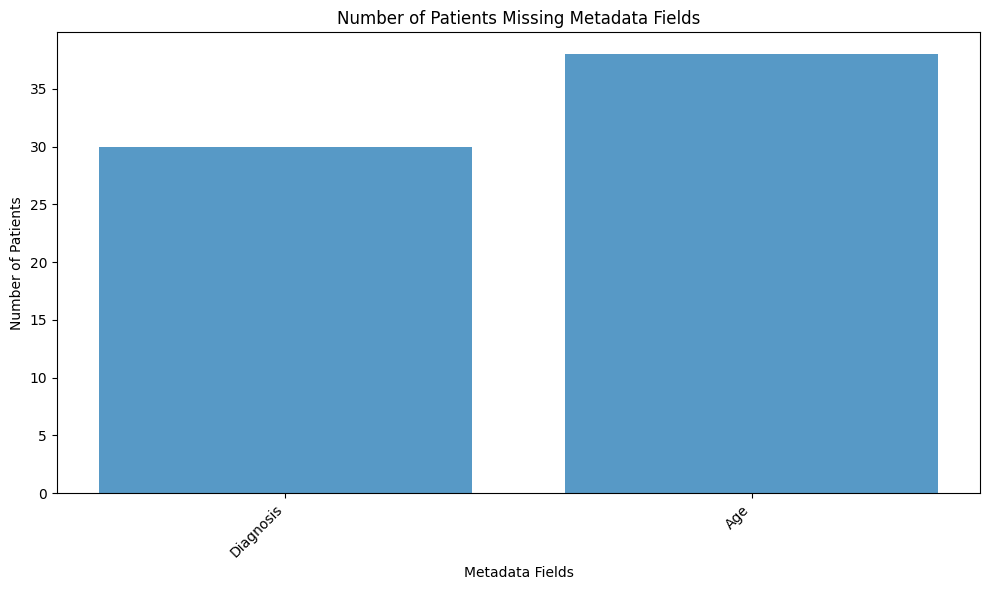

In [ ]:
# Step 1: Load required fields and dataset
required_fields = get_required_metadata()
dataset_path = 'example_metadata_with_issues.csv'
dataset_df = load_dataset_csv(dataset_path)

if dataset_df is not None and required_fields:
    # Step 2: Perform image-level completeness check
    image_completeness_report = image_level_completeness_check(dataset_df, required_fields)

    # Step 3: Save missing data summary
    #save_missing_data_summary("missing_data_summary.csv", image_completeness_report)
    # Step 3: Save missing data summary
    save_missing_data_summary("missing_data_summary.csv", dataset_df, image_completeness_report)


    # Step 4: Plot missing data summary
    plot_missing_data(image_completeness_report)


else:
    print("Failed to load dataset or required fields.")


In [ ]:
def check_patient_completeness(patient_id, dataset_df, missing_data):
    """
    Check if a specific patient is complete and print the missing fields if not.

    Args:
        patient_id (str or int): The Patient ID to check.
        dataset_df (pd.DataFrame): The dataset as a DataFrame.
        missing_data (dict): Dictionary containing missing data details.

    Returns:
        None
    """
    if "PatientID" not in dataset_df.columns:
        print("No PatientID column found in the dataset.")
        return

    # Standardize the Patient ID input and dataset column
    patient_id = str(patient_id).strip()
    dataset_df["PatientID"] = dataset_df["PatientID"].astype(str).str.strip()

    # Find the record by Patient ID
    record_idx = dataset_df.index[dataset_df["PatientID"] == patient_id].tolist()
    if not record_idx:
        print(f"Patient ID {patient_id} not found in the dataset.")
        return

    record_idx = record_idx[0]

    # Check if the record is incomplete
    if record_idx in missing_data["incomplete_records"]:
        missing_fields = missing_data["incomplete_records"][record_idx]
        print(f"Patient ID {patient_id} is incomplete. Missing fields: {missing_fields}")
    else:
        print(f"Patient ID {patient_id} has complete metadata.")

# Interactive Patient Completeness Check
print("Interactive Patient Completeness Check")
patient_id = input("Enter the Patient ID to check completeness: ")
try:
    check_patient_completeness(patient_id, dataset_df, image_completeness_report)
except Exception as e:
    print(f"Error in checking patient completeness: {e}")


Interactive Patient Completeness Check
Enter the Patient ID to check completeness: 142
Patient ID 142 is incomplete. Missing fields: ['Age']


In [ ]:
def check_patient_completeness(patient_id, dataset_df, missing_data, required_fields):
    """
    Check if a specific patient is complete and print the missing fields if not,
    along with the completeness score.

    Args:
        patient_id (str or int): The Patient ID to check.
        dataset_df (pd.DataFrame): The dataset as a DataFrame.
        missing_data (dict): Dictionary containing missing data details.
        required_fields (list): List of required metadata fields.

    Returns:
        None
    """
    if "PatientID" not in dataset_df.columns:
        print("No PatientID column found in the dataset.")
        return

    # Standardize the Patient ID input and dataset column
    patient_id = str(patient_id).strip()
    dataset_df["PatientID"] = dataset_df["PatientID"].astype(str).str.strip()

    # Find the record by Patient ID
    record_idx = dataset_df.index[dataset_df["PatientID"] == patient_id].tolist()
    if not record_idx:
        print(f"Patient ID {patient_id} not found in the dataset.")
        return

    record_idx = record_idx[0]

    # Check if the record is incomplete
    if record_idx in missing_data["incomplete_records"]:
        missing_fields = missing_data["incomplete_records"][record_idx]
        completeness_score = (len(required_fields) - len(missing_fields)) / len(required_fields) * 100
        print(f"Patient ID {patient_id} is incomplete. Missing fields: {missing_fields}")
        print(f"Completeness Score for Patient ID {patient_id}: {completeness_score:.2f}%")
    else:
        print(f"Patient ID {patient_id} has complete metadata.")
        print(f"Completeness Score for Patient ID {patient_id}: 100.00%")


In [ ]:
# Interactive Patient Completeness Check
print("Interactive Patient Completeness Check")
patient_id = input("Enter the Patient ID to check completeness: ")
try:
    check_patient_completeness(patient_id, dataset_df, image_completeness_report, required_fields)
except Exception as e:
    print(f"Error in checking patient completeness: {e}")


Interactive Patient Completeness Check
Enter the Patient ID to check completeness: 2
Patient ID 2 has complete metadata.
Completeness Score for Patient ID 2: 100.00%


In [ ]:
def compute_all_completeness_scores(dataset_df, required_fields):
    """
    Compute the completeness scores for all patients in the dataset and calculate the total average score.

    Args:
        dataset_df (pd.DataFrame): The dataset as a DataFrame.
        required_fields (list): List of required metadata fields.

    Returns:
        tuple: A dictionary of completeness scores for all patients and the total average score.
    """
    completeness_scores = {}  # To store individual completeness scores
    total_score = 0.0  # To accumulate total completeness scores

    # Loop through each record
    for index, row in dataset_df.iterrows():
        # Check missing fields for the current record
        missing_fields = [field for field in required_fields if pd.isna(row[field])]
        completeness_score = (len(required_fields) - len(missing_fields)) / len(required_fields) * 100
        total_score += completeness_score

        # Store the score with PatientID if available, otherwise use index
        if "PatientID" in dataset_df.columns:
            patient_id = row["PatientID"]
        else:
            patient_id = index + 1  # Use 1-based index if PatientID is not present

        completeness_scores[patient_id] = completeness_score

    # Compute the average completeness score
    average_score = total_score / len(dataset_df)

    return completeness_scores, average_score


In [ ]:
# Validate required fields against dataset columns
valid_required_fields = [field for field in required_fields if field in dataset_df.columns]

# Warn about invalid fields
invalid_fields = [field for field in required_fields if field not in dataset_df.columns]
if invalid_fields:
    print(f"Warning: The following required fields are not present in the dataset columns: {invalid_fields}")

# Replace required_fields with valid_required_fields for further processing
required_fields = valid_required_fields


In [ ]:
def plot_completeness_scores_histogram(completeness_scores):
    """
    Plot a histogram summarizing the completeness scores.

    Args:
        completeness_scores (dict): A dictionary of patient IDs and their completeness scores.

    Returns:
        None
    """
    scores = list(completeness_scores.values())  # Extract all scores

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=10, edgecolor='black', alpha=0.75, range=(0, 100))  # Bin scores from 0 to 100

    # Add labels and title
    plt.title("Completeness Scores Distribution", fontsize=16)
    plt.xlabel("Completeness Score (%)", fontsize=14)
    plt.ylabel("Frequency of Patients", fontsize=14)
    plt.xticks(range(0, 101, 10))  # Set x-axis ticks for every 10% range
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()


Provide the path to the required metadata fields CSV file.
Enter the full path to the file (e.g., '/path/to/file.csv'): 'required_metadata_headers.csv'
Required fields: ['RequiredHeaders', 'PatientID', 'Age', 'Gender', 'Diagnosis']
Missing data summary saved to missing_data_summary.csv


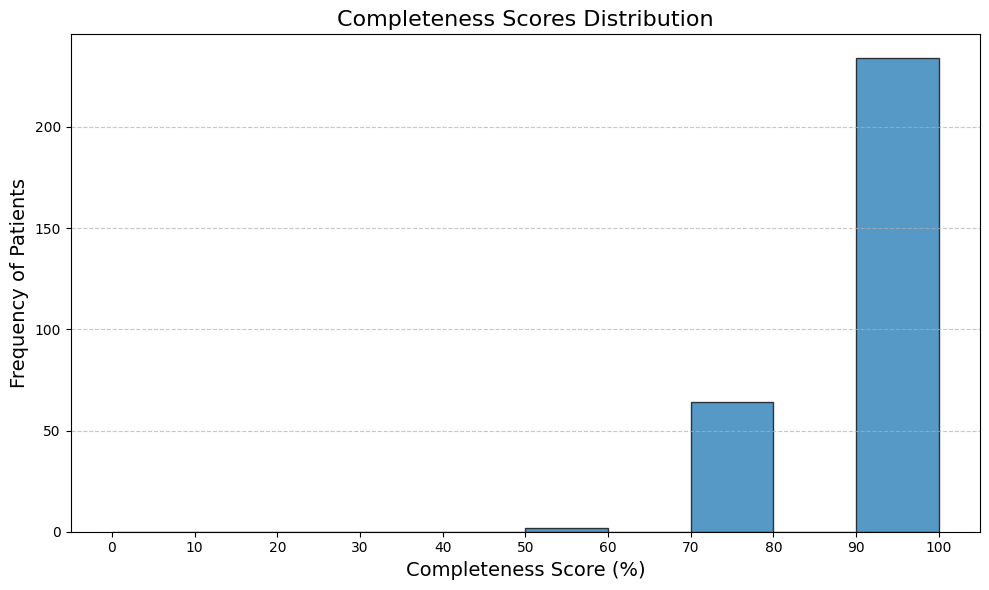

Completeness Scores for All Patients:
  Patient ID 1: 100.00%
  Patient ID 2: 100.00%
  Patient ID 3: 100.00%
  Patient ID 4: 100.00%
  Patient ID 5: 100.00%
  Patient ID 6: 100.00%
  Patient ID 7: 75.00%
  Patient ID 8: 100.00%
  Patient ID 9: 100.00%
  Patient ID 10: 100.00%
  Patient ID 11: 100.00%
  Patient ID 12: 75.00%
  Patient ID 13: 75.00%
  Patient ID 14: 100.00%
  Patient ID 15: 100.00%
  Patient ID 16: 100.00%
  Patient ID 17: 100.00%
  Patient ID 18: 100.00%
  Patient ID 19: 100.00%
  Patient ID 20: 100.00%
  Patient ID 21: 100.00%
  Patient ID 22: 100.00%
  Patient ID 23: 100.00%
  Patient ID 24: 75.00%
  Patient ID 25: 100.00%
  Patient ID 26: 100.00%
  Patient ID 27: 100.00%
  Patient ID 28: 100.00%
  Patient ID 29: 100.00%
  Patient ID 30: 100.00%
  Patient ID 31: 75.00%
  Patient ID 32: 75.00%
  Patient ID 33: 100.00%
  Patient ID 34: 100.00%
  Patient ID 35: 100.00%
  Patient ID 36: 100.00%
  Patient ID 37: 100.00%
  Patient ID 38: 100.00%
  Patient ID 39: 100.00%
  

In [ ]:
# Step 1: Load required fields and dataset
required_fields = get_required_metadata()
dataset_path = 'example_metadata_with_issues.csv'
dataset_df = load_dataset_csv(dataset_path)

if dataset_df is not None and required_fields:
    # Validate required fields
    valid_required_fields = [field for field in required_fields if field in dataset_df.columns]
    invalid_fields = [field for field in required_fields if field not in dataset_df.columns]
    if invalid_fields:
        print(f"Warning: The following required fields are not present in the dataset columns: {invalid_fields}")
    required_fields = valid_required_fields

    # Step 2: Perform image-level completeness check
    image_completeness_report = image_level_completeness_check(dataset_df, required_fields)

    # Step 3: Save missing data summary
    save_missing_data_summary("missing_data_summary.csv", dataset_df, image_completeness_report)

    # Step 4: Plot completeness scores
    completeness_scores, average_score = compute_all_completeness_scores(dataset_df, required_fields)
    plot_completeness_scores_histogram(completeness_scores)

    # Step 5: Print completeness scores
    print("Completeness Scores for All Patients:")
    for patient_id, score in completeness_scores.items():
        print(f"  Patient ID {patient_id}: {score:.2f}%")
    print(f"\nTotal Average Completeness Score: {average_score:.2f}%")
else:
    print("Failed to load dataset or required fields.")
